In [1]:
import sys
sys.path.append("../cs224u")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
import vsm

We'll begin by reading in all of the data and printing a few rows from each CSV file

In [9]:
analysts = pd.read_csv('./data/analysts.csv')
print(analysts.shape)
analysts.head(10)

(187327, 12)


num           file-company-name file-exchange file-symbol  \
0    1       Ark Restaurants Corp.        NASDAQ        ARKR   
1    2              UniFirst Corp.          NYSE         UNF   
2    2              UniFirst Corp.          NYSE         UNF   
3    2              UniFirst Corp.          NYSE         UNF   
4    2              UniFirst Corp.          NYSE         UNF   
5    3  Resources Connection, Inc.        NASDAQ        RECN   
6    3  Resources Connection, Inc.        NASDAQ        RECN   
7    3  Resources Connection, Inc.        NASDAQ        RECN   
8    4                 Sonic Corp.        NASDAQ        SONC   
9    4                 Sonic Corp.        NASDAQ        SONC   

     file-published-on                                         file-title  \
0  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
1  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
2  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
3  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
4  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
5  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
6  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
7  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
8  2017-01-04 21:41:07  Sonic's (SONC) CEO Cliff Hudson on Q1 2017 Res...   
9  2017-01-04 21:41:07  Sonic's (SONC) CEO Cliff Hudson on Q1 2017 Res...   

                 company-name                        quarter-year-event  \
0       Ark Restaurants Corp.          Q4 2016 Earnings Conference Call   
1       UniFirst Corporation.          Q1 2017 Earnings Conference Call   
2       UniFirst Corporation.          Q1 2017 Earnings Conference Call   
3       UniFirst Corporation.          Q1 2017 Earnings Conference Call   
4       UniFirst Corporation.          Q1 2017 Earnings Conference Call   
5  Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
6  Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
7  Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
8                 Sonic Corp.  Q1 2017 Results Earnings Conference Call   
9                 Sonic Corp.  Q1 2017 Results Earnings Conference Call   

  symbol-exchange symbol                         datetime  \
0             NaN   ARKR  December 30, 2016 10:00 A.M. ET   
1             NaN    UNF      January 4, 2017 10:00 AM ET   
2             NaN    UNF      January 4, 2017 10:00 AM ET   
3             NaN    UNF      January 4, 2017 10:00 AM ET   
4             NaN    UNF      January 4, 2017 10:00 AM ET   
5             NaN   RECN         January 4, 2017 17:00 ET   
6             NaN   RECN         January 4, 2017 17:00 ET   
7             NaN   RECN         January 4, 2017 17:00 ET   
8             NaN   SONC     January 04, 2017 05:00 PM ET   
9             NaN   SONC     January 04, 2017 05:00 PM ET   

                                     analyst-company  
0                                Bruce Geller - DGHM  
1                   John Healy - Northcoast Research  
2  Kevin Steinke - Barrington Research Associates...  
3                  Joe Box - KeyBanc Capital Markets  
4     Justin Hauke - Robert W. Baird & Company, Inc.  
5                       Andrew Steinerman - JPMorgan  
6                      Kevin McVeigh - Deutsche Bank  
7                                Mark Marcon - Baird  
8                   Greg Francfort - Bank of America  
9                      Nicole Miller - Piper Jaffray

In [10]:
execs = pd.read_csv('./data/executives.csv')
print(execs.shape)
execs.head(10)

(111916, 12)


num               file-company-name file-exchange file-symbol  \
0    1           Ark Restaurants Corp.        NASDAQ        ARKR   
1    1           Ark Restaurants Corp.        NASDAQ        ARKR   
2    2                  UniFirst Corp.          NYSE         UNF   
3    2                  UniFirst Corp.          NYSE         UNF   
4    3      Resources Connection, Inc.        NASDAQ        RECN   
5    3      Resources Connection, Inc.        NASDAQ        RECN   
6    3      Resources Connection, Inc.        NASDAQ        RECN   
7    4                     Sonic Corp.        NASDAQ        SONC   
8    4                     Sonic Corp.        NASDAQ        SONC   
9    5  Walgreens Boots Alliance, Inc.        NASDAQ         WBA   

     file-published-on                                         file-title  \
0  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
1  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
2  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
3  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
4  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
5  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
6  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   
7  2017-01-04 21:41:07  Sonic's (SONC) CEO Cliff Hudson on Q1 2017 Res...   
8  2017-01-04 21:41:07  Sonic's (SONC) CEO Cliff Hudson on Q1 2017 Res...   
9  2017-01-05 16:33:05  Walgreens Boots Alliance's (WBA) CEO Stefano P...   

                     company-name                        quarter-year-event  \
0           Ark Restaurants Corp.          Q4 2016 Earnings Conference Call   
1           Ark Restaurants Corp.          Q4 2016 Earnings Conference Call   
2           UniFirst Corporation.          Q1 2017 Earnings Conference Call   
3           UniFirst Corporation.          Q1 2017 Earnings Conference Call   
4      Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
5      Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
6      Resources Connection, Inc.          Q2 2017 Earnings Conference Call   
7                     Sonic Corp.  Q1 2017 Results Earnings Conference Call   
8                     Sonic Corp.  Q1 2017 Results Earnings Conference Call   
9  Walgreens Boots Alliance, Inc.  Q1 2017 Results Earnings Conference Call   

  symbol-exchange symbol                         datetime  \
0             NaN   ARKR  December 30, 2016 10:00 A.M. ET   
1             NaN   ARKR  December 30, 2016 10:00 A.M. ET   
2             NaN    UNF      January 4, 2017 10:00 AM ET   
3             NaN    UNF      January 4, 2017 10:00 AM ET   
4             NaN   RECN         January 4, 2017 17:00 ET   
5             NaN   RECN         January 4, 2017 17:00 ET   
6             NaN   RECN         January 4, 2017 17:00 ET   
7             NaN   SONC     January 04, 2017 05:00 PM ET   
8             NaN   SONC     January 04, 2017 05:00 PM ET   
9             NaN    WBA    January 05, 2017, 08:30 AM ET   

                                 executive-positions  
0  Bob Stewart - President and Chief Financial Of...  
1  Michael Weinstein - Chairman and Chief Executi...  
2                 Ronald Croatti - President and CEO  
3                       Steven Sintros - SVP and CFO  
4         Alice Washington - Interim General Counsel  
5             Kate Duchene - Chief Executive Officer  
6             Herb Mueller - Chief Financial Officer  
7                                 Cliff Hudson - CEO  
8                            Claudia San Pedro - CFO  
9  Gerald Gradwell - Senior Vice President, Inves...

In [11]:
qna = pd.read_csv('./data/qna.csv')
print(qna.shape)
qna.head(10)

(1828257, 14)


num      file-company-name file-exchange file-symbol    file-published-on  \
0    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
1    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
2    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
3    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
4    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
5    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
6    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
7    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
8    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   
9    1  Ark Restaurants Corp.        NASDAQ        ARKR  2017-01-01 06:49:04   

                                          file-title           company-name  \
0  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
1  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
2  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
3  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
4  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
5  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
6  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
7  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
8  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   
9  Ark Restaurants' (ARKR) CEO Michael Weinstein ...  Ark Restaurants Corp.   

                 quarter-year-event symbol-exchange symbol  \
0  Q4 2016 Earnings Conference Call             NaN   ARKR   
1  Q4 2016 Earnings Conference Call             NaN   ARKR   
2  Q4 2016 Earnings Conference Call             NaN   ARKR   
3  Q4 2016 Earnings Conference Call             NaN   ARKR   
4  Q4 2016 Earnings Conference Call             NaN   ARKR   
5  Q4 2016 Earnings Conference Call             NaN   ARKR   
6  Q4 2016 Earnings Conference Call             NaN   ARKR   
7  Q4 2016 Earnings Conference Call             NaN   ARKR   
8  Q4 2016 Earnings Conference Call             NaN   ARKR   
9  Q4 2016 Earnings Conference Call             NaN   ARKR   

                          datetime  order                 name  \
0  December 30, 2016 10:00 A.M. ET      1             Operator   
1  December 30, 2016 10:00 A.M. ET      2         Bruce Geller   
2  December 30, 2016 10:00 A.M. ET      3          Bob Stewart   
3  December 30, 2016 10:00 A.M. ET      4         Bruce Geller   
4  December 30, 2016 10:00 A.M. ET      5          Bob Stewart   
5  December 30, 2016 10:00 A.M. ET      6         Bruce Geller   
6  December 30, 2016 10:00 A.M. ET      7          Bob Stewart   
7  December 30, 2016 10:00 A.M. ET      8  Bruce Howard Geller   
8  December 30, 2016 10:00 A.M. ET      9          Bob Stewart   
9  December 30, 2016 10:00 A.M. ET     10         Bruce Geller   

                                             content  
0  [Operator Instructions] Our first question com...  
1                              Hi Good morning guys.  
2                             Hi Bruce, how are you?  
3  Good thanks. Glad to hear things have turned a...  
4  Yes, that includes an additional week last yea...  
5                           So it's not nearly as...  
6                                            No, no.  
7  …as dismal as it might imply. What were the ap...  
8  About 2%. Probably down, somewhere along that ...  
9  Got it. Okay. Can you just kind of go through ...

In [12]:
statements = pd.read_csv('./data/statements.csv')
print(statements.shape)
statements.head(10)

(204656, 14)


num           file-company-name file-exchange file-symbol  \
0    1       Ark Restaurants Corp.        NASDAQ        ARKR   
1    1       Ark Restaurants Corp.        NASDAQ        ARKR   
2    1       Ark Restaurants Corp.        NASDAQ        ARKR   
3    1       Ark Restaurants Corp.        NASDAQ        ARKR   
4    2              UniFirst Corp.          NYSE         UNF   
5    2              UniFirst Corp.          NYSE         UNF   
6    2              UniFirst Corp.          NYSE         UNF   
7    2              UniFirst Corp.          NYSE         UNF   
8    2              UniFirst Corp.          NYSE         UNF   
9    3  Resources Connection, Inc.        NASDAQ        RECN   

     file-published-on                                         file-title  \
0  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
1  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
2  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
3  2017-01-01 06:49:04  Ark Restaurants' (ARKR) CEO Michael Weinstein ...   
4  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
5  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
6  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
7  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
8  2017-01-04 13:33:06  UniFirst's (UNF) CEO Ronald Croatti on Q1 2017...   
9  2017-01-04 23:16:06  Resources Connection's (RECN) CEO Kate Duchene...   

                 company-name                quarter-year-event  \
0       Ark Restaurants Corp.  Q4 2016 Earnings Conference Call   
1       Ark Restaurants Corp.  Q4 2016 Earnings Conference Call   
2       Ark Restaurants Corp.  Q4 2016 Earnings Conference Call   
3       Ark Restaurants Corp.  Q4 2016 Earnings Conference Call   
4       UniFirst Corporation.  Q1 2017 Earnings Conference Call   
5       UniFirst Corporation.  Q1 2017 Earnings Conference Call   
6       UniFirst Corporation.  Q1 2017 Earnings Conference Call   
7       UniFirst Corporation.  Q1 2017 Earnings Conference Call   
8       UniFirst Corporation.  Q1 2017 Earnings Conference Call   
9  Resources Connection, Inc.  Q2 2017 Earnings Conference Call   

  symbol-exchange symbol                         datetime  order  \
0             NaN   ARKR  December 30, 2016 10:00 A.M. ET      1   
1             NaN   ARKR  December 30, 2016 10:00 A.M. ET      2   
2             NaN   ARKR  December 30, 2016 10:00 A.M. ET      3   
3             NaN   ARKR  December 30, 2016 10:00 A.M. ET      4   
4             NaN    UNF      January 4, 2017 10:00 AM ET      1   
5             NaN    UNF      January 4, 2017 10:00 AM ET      2   
6             NaN    UNF      January 4, 2017 10:00 AM ET      3   
7             NaN    UNF      January 4, 2017 10:00 AM ET      4   
8             NaN    UNF      January 4, 2017 10:00 AM ET      5   
9             NaN   RECN         January 4, 2017 17:00 ET      1   

                name                                            content  
0       Presentation                                                NaN  
1           Operator  Greetings, and welcome to the Ark Restaurants ...  
2        Bob Stewart  Thank you, operator. Good morning, and thank y...  
3  Michael Weinstein  Hi, everybody. If you read the release, we're ...  
4       Presentation                                                NaN  
5           Operator  Ladies and gentlemen, thank you for standing b...  
6     Steven Sintros  Thank you and welcome to the UniFirst Corporat...  
7     Ronald Croatti  Thank you, Steve. I'd like to welcome everyone...  
8     Steven Sintros  Thanks, Ron. As Ron mentioned, revenues for th...  
9       Presentation                                                NaN

Let's begin by seeing how many distinct statements and Q&A sessions we have (these numbers should be appx. the same, but some statements may not have a corresponding Q&A session).

In [13]:
num_statements = 0
for i in range(statements.shape[0]):
    if statements.iloc[i]['order'] == 1: num_statements += 1
    
num_qna = 0
for i in range(qna.shape[0]):
    if qna.iloc[i]['order'] == 1: num_qna += 1
        
print("There are %s distinct statements" % str(num_statements))
print("There are %s distinct Q&A sessions" % str(num_qna))

There are 33227 distinct statements
There are 33019 distinct Q&A sessions


Now let's look at a complete statement and its corresponding Q&A session.

In [14]:
def get_first_k_examples(k, verbose=False):
    results = []
    num_processed = 0
    row_statement, row_qna = 0, 0
    while num_processed < k:
        curr = {}
        curr['statement'] = []
        curr['qna'] = []
        while(True):
            if len(curr['statement']) > 0 and statements.iloc[row_statement]['order'] == 1: break
            curr_speaker = str(statements.iloc[row_statement]['name'])
            if verbose: print(curr_speaker + '\n')
            curr_content = str(statements.iloc[row_statement]['content'])
            if verbose: print(curr_content + '\n')
            curr['statement'].append((row_statement, curr_speaker, curr_content))
            row_statement += 1

        if verbose:
            print('=' * 75 + '\n')
            print("Moving on to Q&A\n")
            print('=' * 75 + '\n')

        while(True):
            if len(curr['qna']) > 0 and qna.iloc[row_qna]['order'] == 1: break
            curr_speaker = str(qna.iloc[row_qna]['name'])
            if verbose: print(curr_speaker + '\n')
            curr_content = str(qna.iloc[row_qna]['content'])
            if verbose: print(curr_content + '\n')
            curr['qna'].append((row_qna, curr_speaker, curr_content))
            row_qna += 1
        results.append(curr)
        num_processed += 1
    return results

In [18]:
get_first_k_examples(k=1, verbose=True)

Presentation

nan

Operator

Greetings, and welcome to the Ark Restaurants Fourth Quarter and Full Year 2016 Results Conference. At this time, all participants are in a listen-only mode. A question-and-answer session will follow the formal presentation. [Operator Instructions] As a reminder, this conference is being recorded.; ; I would now like to turn the conference over to your host, Mr. Bob Stewart, President and Chief Financial Officer. Thank you. You may begin.

Bob Stewart

Thank you, operator. Good morning, and thank you for joining us on our conference call for the fourth fiscal quarter and full year ended October 1, 2016. With me on the call today is Michael Weinstein, our Chairman and CEO; and Vinny Pascal, our Chief Operating Officer.; ; For those of you who have not yet obtained the copy of our press release, it was issued over the newswire yesterday and is available on our website. To review the full text of that press release along with the associated financial tables, p

[{'statement': [(0, 'Presentation', 'nan'),
   (1,
    'Operator',
    'Greetings, and welcome to the Ark Restaurants Fourth Quarter and Full Year 2016 Results Conference. At this time, all participants are in a listen-only mode. A question-and-answer session will follow the formal presentation. [Operator Instructions] As a reminder, this conference is being recorded.; ; I would now like to turn the conference over to your host, Mr. Bob Stewart, President and Chief Financial Officer. Thank you. You may begin.'),
   (2,
    'Bob Stewart',
    "Thank you, operator. Good morning, and thank you for joining us on our conference call for the fourth fiscal quarter and full year ended October 1, 2016. With me on the call today is Michael Weinstein, our Chairman and CEO; and Vinny Pascal, our Chief Operating Officer.; ; For those of you who have not yet obtained the copy of our press release, it was issued over the newswire yesterday and is available on our website. To review the full text of t

Now let's examine the value returned by get_first_k_examples

In [19]:
samples = get_first_k_examples(100, verbose=False)
print("%s samples were returned" % len(samples))

100 samples were returned


Now let's examine the speakers in both the statement and Q&A sections 

In [20]:
# Parse out the speakers
statement_speakers = []
qna_speakers = []
for ex in samples:
    for elem in ex['statement']:
        curr_speaker = elem[1]
        statement_speakers.append(curr_speaker)
    for elem in ex['qna']:
        curr_speaker = elem[1]
        qna_speakers.append(curr_speaker)
print("There are %s distinct speakers in the statements section" % len(set(statement_speakers)))
print("There are %s distinct speakers in the Q&A section" % len(set(qna_speakers)))

There are 265 distinct speakers in the statements section
There are 858 distinct speakers in the Q&A section


In [21]:
# Count the number of times each speaker spoke
statement_speakers_counts = Counter(statement_speakers)
qna_speakers_counts = Counter(qna_speakers)

# Remove 'Operator' and 'Presentation' speakers
del statement_speakers_counts['Presentation']
del statement_speakers_counts['Operator']
del qna_speakers_counts['Operator']

print("There are %s distinct speaker count values for the statements" % len(set(statement_speakers_counts.values())))
print(sorted(set(statement_speakers_counts.values())))
print('')

print("There are %s distinct speaker count values for the Q&A" % len(set(qna_speakers_counts.values())))
print(sorted(set(qna_speakers_counts.values())))

There are 5 distinct speaker count values for the statements
[1, 2, 3, 10, 12]

There are 44 distinct speaker count values for the Q&A
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 41, 44, 51, 57, 58, 67, 69, 75, 95]


In [22]:
# Let's get the key corresponding to the highest Q&A speaker count
for key in qna_speakers_counts.keys():
    if qna_speakers_counts[key] == 95: print(key)

Unidentified Analyst


Now let's examine the vocabularies in both the statement and Q&A sections. We will drop stop words and for each token we will ensure its length is greater than 1 to get rid of punctuation.

In [23]:
# Define our set of stop words
stop_words = set(stopwords.words('english'))
print(stop_words)

{'which', "weren't", 'while', 'myself', 'yourselves', 'needn', 'y', 'didn', 'were', 'had', "don't", 'such', 'her', 'so', 'during', 'we', "wouldn't", 'if', 'theirs', "mightn't", 'above', 'when', "you'd", 'for', 'these', "it's", 'shouldn', 'from', 'o', 'each', 'just', 'them', 'now', 'ma', 'aren', 'mustn', 'or', 'own', 'over', 'shan', 'don', 'can', "doesn't", 'all', 'my', 'will', 'itself', 'under', 'wouldn', 'she', 'no', 'm', 'in', "you're", 'i', 'nor', 'it', 'of', 've', 'doing', 'd', 'their', 'until', 'mightn', 'there', 'up', 'isn', 'few', 'was', "you'll", 'being', 'with', "shouldn't", 'the', 'where', 'by', 'other', 'ourselves', 'yours', 'its', "hadn't", 'but', 'what', "couldn't", 'ain', 'does', 't', "you've", 'why', 'not', 'whom', 'ours', 'too', 'should', 'have', 'hadn', 'both', 'then', 'do', 'out', 'you', 'who', 'only', "mustn't", "she's", "won't", 'those', "that'll", 'same', 'against', 'doesn', 'couldn', 'haven', 'they', 'most', 'that', 'to', 'how', "aren't", 'this', 'has', 'on', 'him

In [24]:
# Parse out content
statement_tokens = []
qna_tokens = []
for ex in samples:
    for elem in ex['statement']:
        curr_tokens = elem[2]
        curr_tokens = word_tokenize(curr_tokens)
        curr_tokens = [tok.lower() for tok in curr_tokens if (not tok.lower() in stop_words and tok.isalnum())]
        statement_tokens.extend(curr_tokens)
    for elem in ex['qna']:
        curr_tokens = elem[2]
        curr_tokens = word_tokenize(curr_tokens)
        curr_tokens = [tok.lower() for tok in curr_tokens if (not tok.lower() in stop_words and tok.isalnum())]
        qna_tokens.extend(curr_tokens)
print("There are %s distinct tokens in the statements section" % len(set(statement_tokens)))
print("There are %s distinct tokens in the Q&A section" % len(set(qna_tokens)))

There are 10098 distinct tokens in the statements section
There are 11421 distinct tokens in the Q&A section


In [25]:
# Count the number of times each token appeared
statement_token_counts = Counter(statement_tokens)
qna_token_counts = Counter(qna_tokens)

print("There are %s distinct token count values for the statements" % len(set(statement_token_counts.values())))
print(sorted(set(statement_token_counts.values())))
print('')

print("There are %s distinct token count values for the Q&A" % len(set(qna_token_counts.values())))
print(sorted(set(qna_token_counts.values())))

There are 272 distinct token count values for the statements
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 159, 160, 161, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 192, 195, 197, 199, 202, 204, 205, 206, 212, 214, 216, 217, 219, 221, 222, 232, 233, 236, 239, 243, 246, 247, 248, 251, 253, 258, 261, 262, 263, 265, 279, 285, 2

In [42]:
# Let's look at the frequency distributions for both the statement and Q&A sections
statements_fdist = FreqDist(statement_tokens)
qna_fdist = FreqDist(qna_tokens)

In [43]:
print("Here are the most common words in the statements:")
print(statements_fdist.most_common(100))

Here are the most common words in the statements:
[('quarter', 2639), ('million', 2228), ('year', 1954), ('growth', 1046), ('business', 924), ('first', 859), ('2017', 858), ('fiscal', 830), ('new', 814), ('2016', 813), ('sales', 802), ('call', 718), ('revenue', 692), ('net', 688), ('last', 650), ('also', 632), ('results', 612), ('continue', 610), ('us', 602), ('market', 596), ('billion', 557), ('fourth', 552), ('well', 522), ('compared', 511), ('expect', 508), ('share', 502), ('income', 495), ('basis', 488), ('increase', 486), ('operating', 479), ('company', 479), ('strong', 462), ('today', 457), ('increased', 451), ('financial', 449), ('second', 449), ('cash', 426), ('third', 410), ('like', 398), ('see', 398), ('good', 395), ('earnings', 393), ('would', 392), ('performance', 386), ('time', 372), ('due', 372), ('margin', 366), ('per', 353), ('higher', 353), ('approximately', 350), ('thank', 345), ('one', 343), ('total', 340), ('cost', 338), ('customers', 331), ('rate', 329), ('capital'

In [44]:
print("Here are the most common words in the statements:")
print(qna_fdist.most_common(100))

Here are the most common words in the statements:
[('think', 3023), ('would', 1858), ('question', 1809), ('year', 1801), ('going', 1652), ('quarter', 1379), ('business', 1282), ('see', 1282), ('good', 1259), ('us', 1213), ('really', 1167), ('one', 1153), ('thank', 1142), ('well', 1028), ('okay', 1012), ('next', 967), ('like', 960), ('growth', 960), ('get', 914), ('look', 901), ('last', 872), ('first', 864), ('new', 847), ('much', 845), ('right', 840), ('yes', 835), ('little', 808), ('go', 788), ('bit', 788), ('market', 780), ('time', 780), ('could', 777), ('terms', 748), ('know', 745), ('kind', 723), ('line', 720), ('lot', 709), ('thanks', 696), ('things', 682), ('also', 682), ('say', 677), ('back', 647), ('maybe', 632), ('million', 617), ('rate', 589), ('said', 572), ('comes', 562), ('got', 557), ('sales', 555), ('two', 551), ('years', 542), ('continue', 540), ('point', 539), ('mean', 519), ('expect', 510), ('obviously', 509), ('great', 508), ('morning', 505), ('still', 503), ('take',

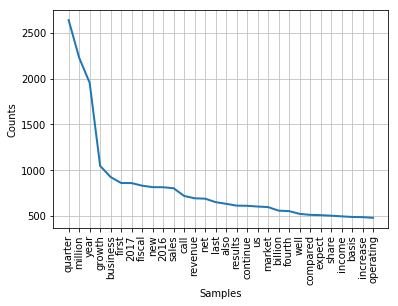

In [38]:
statements_fdist.plot(30, cumulative=False)

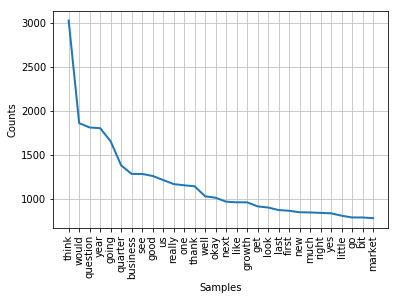

In [37]:
qna_fdist.plot(30, cumulative=False)